In [6]:
!pip install statsmodels plotly mpl_finance torch pandas matplotlib

  Using cached https://files.pythonhosted.org/packages/a1/1f/a372f2e9f0a54fc479fcee3ac072f8cd5091054e9d7293dd4372338e5277/torch-1.9.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2e/35/6c4fff5ab443b57116cb1aad46421fb719bed2825664e8fe77d66d99bcbc/typing_extensions-3.10.0.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fe/ca/75fac5856ab5cfa51bbbcefa250182e50441074fdc3f803f6e76451fab43/dataclasses-0.8-py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import torch
import torch.nn as nn
#from network import *
from data import *
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import math
from mpl_finance import candlestick_ohlc
import json

/usr/local/lib/python3.6/dist-packages/mpl_finance.py:22: DeprecationWarning:





    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/





In [2]:
print("Loading : ")

#train_data 
# List( 
#  Pandas.Dataframe[행(2018 ~ 2019) * 열(index, open time, ... , month) ] - BTC,
#  Pandas.Dataframe[행(2018 ~ 2019) * 열(index, open time, ... , month) ] - ETH, 
#  Pandas.Dataframe[행(2018 ~ 2019) * 열(index, open time, ... , month) ] - LTC
#)
train_data = load_data(['2018', '2019'], ['BTCUSDT', 'ETHUSDT','LTCUSDT'], '5m')
test_data = load_data(['2020'], ['BTCUSDT', 'ETHUSDT', 'LTCUSDT'], '5m')
# train_data = load_data(['2020'], ['BTCUSDT', 'ETHUSDT', 'LTCUSDT'], '5m')

Loading : 
done
done


In [28]:
print(len(train_data))
print(train_data[0].shape)
print(train_data[1].shape)
print(train_data[2].shape)

print(len(test_data))
print(test_data[0].shape)
print(test_data[1].shape)
print(test_data[2].shape)

3
(211138, 10)
(211138, 10)
(211137, 10)
3
(105685, 10)
(105685, 10)
(105685, 10)


In [37]:
train_data

[          0     Open Time      Open      High       Low     Close     Volume  \
 0         0  1.514765e+12  13715.65  13715.65  13576.28  13600.00  33.617798   
 1         1  1.514765e+12  13600.00  13600.00  13501.01  13554.58  40.528679   
 2         2  1.514765e+12  13554.58  13569.97  13400.01  13556.15  49.469536   
 3         3  1.514766e+12  13533.75  13547.73  13402.00  13430.52  32.725614   
 4         4  1.514766e+12  13440.01  13459.99  13410.44  13439.94  26.614135   
 ...     ...           ...       ...       ...       ...       ...        ...   
 105286  115  1.577835e+12   7189.54   7193.42   7187.69   7191.86  34.360944   
 105287  116  1.577836e+12   7192.51   7199.00   7191.91   7195.43  25.521108   
 105288  117  1.577836e+12   7195.70   7198.94   7193.48   7194.79  30.479906   
 105289  118  1.577836e+12   7194.38   7205.98   7192.24   7204.03  33.066805   
 105290  119  1.577836e+12   7204.25   7206.29   7190.17   7195.23  76.038334   
 
         Hour   Day  Month

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import math
import time 


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def a_norm(Q, K):
    m = torch.matmul(Q, K.transpose(2,1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
    return torch.softmax(m , -1)

def attention(Q, K, V):
    #Attention(Q, K, V) = norm(QK)V
    a = a_norm(Q, K) #(batch_size, dim_attn, seq_length)
    return  torch.matmul(a,  V) #(batch_size, seq_length, seq_length)

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn):
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val)
        self.key = Key(dim_val, dim_attn)
        self.query = Query(dim_val, dim_attn)
    
    def forward(self, x, kv = None):
        if(kv is None):
            #Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        
        #Attention with x as Q, external vector kv as K an V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.heads = nn.ModuleList(self.heads)
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False)
    
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
    
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
    
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))

from data import one_hot
def forward_pass(model, data_gen, batch_size, quantiles, indexer = None, gpu = True, one_hot_lens = [24, 31, 12], loss = True):
    if(type(data_gen) != type([])):
        data_gen = [data_gen]
    n_coins = len(data_gen)
     
    if(gpu):
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor
    #model.reset(batch_size, gpu = gpu)
    
    static = torch.arange(0, n_coins).unsqueeze(0).repeat(batch_size,1).transpose(1,0).flatten()
    static = static.unsqueeze(-1).unsqueeze(-1).float().type(dtype)
    static = one_hot(static, [5])
    
    in_seq_continuous, in_seq_discrete, future_in_seq_discrete, target_seq, mask  = next(data_gen[0])
    
    for gen in data_gen[1:]:
        n0, n1, n2, n3, n4  = next(gen)
        
        in_seq_continuous = np.concatenate((in_seq_continuous, n0), 0)
        in_seq_discrete = np.concatenate((in_seq_discrete, n1), 0)
        future_in_seq_discrete = np.concatenate((future_in_seq_discrete, n2), 0)
        target_seq = np.concatenate((target_seq, n3), 0)
        mask = np.concatenate((mask, n4), 0)
                                           
    
    
    in_seq_continuous = torch.tensor(in_seq_continuous).type(dtype).unsqueeze(-1)
    in_seq_discrete =  one_hot(torch.tensor(in_seq_discrete).type(dtype), one_hot_lens)
    future_in_seq_discrete = one_hot(torch.tensor(future_in_seq_discrete).type(dtype), one_hot_lens)
    target_seq = torch.tensor(target_seq).type(dtype)
    mask = torch.tensor(mask).type(dtype).unsqueeze(-1)
    
    #forward pass
#     net_out, vs_weights, _ = model(in_seq_continuous, in_seq_discrete, None,future_in_seq_discrete, static, mask, n_coins = n_coins)
    net_out, vs_weights = model(in_seq_continuous, in_seq_discrete, None,future_in_seq_discrete, static, n_coins)
#     net_out, vs_weights, _ = model(in_seq_continuous, in_seq_discrete, None,future_in_seq_discrete, static)
    
    if loss:
        loss = torch.mean(QuantileLoss(net_out, target_seq ,quantiles), dim = -1)
        loss = loss.reshape([batch_size, n_coins, loss.shape[-1]])
        loss = torch.mean(loss, dim = -1)
        coin_losses = torch.mean(loss, dim = 0)
        loss = torch.mean(loss, dim = -1)
        if not (indexer is None):
            indexer.next(loss.cpu().detach().numpy())
        #loss = torch.mean(loss)



        #start_time = time.time()    
        #print("--- %s seconds ---" % (time.time() - start_time))
        return coin_losses, net_out, vs_weights, (in_seq_continuous, in_seq_discrete, future_in_seq_discrete, target_seq)
    else:
        if not (indexer is None):
            indexer.next()
        return net_out, vs_weights, (in_seq_continuous, in_seq_discrete, future_in_seq_discrete, target_seq)
################################################################################################################

#Static Covariate Encoder
class SCE(torch.nn.Module):
    def __init__(self, n_var_cont, n_var_disc, dim_model, n_outs = 4):
        super(SCE, self).__init__()
        self.v_selection = VSN(n_var_cont, n_var_disc, dim_model).cuda()
        self.outs = []
        for i in range(n_outs):
            self.outs.append(GRN(dim_model).cuda())
        
    def forward(self, x_cont, x_disc):
        x, vs_weights = self.v_selection(x_cont, x_disc)
        c = []
        for i in self.outs:
            c.append(i(x))
        
        return c, vs_weights

#Gated Linear Unit
class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x)

#Gated Reccurent Network
class GRN(torch.nn.Module):
    def __init__(self, dim_input, dim_c = 0, dim_out = None, n_hidden = 10, dropout_r = 0.1):
        super(GRN, self).__init__()
        
        if(dim_out != None):
            self.skip = nn.Linear(dim_input, dim_out)
        else:
            self.skip = None
            dim_out = dim_input
        
        self.fc1 = nn.Linear(dim_input + dim_c, n_hidden)
        self.fc2 = nn.Linear(n_hidden, dim_out)
        self.dropout = nn.Dropout(dropout_r)
        
        self.gate = GLU(dim_out)
        
        self.norm = nn.LayerNorm(dim_out)
    
    #x : (batch_size, seq_len, dim_model)
    def forward(self, x, c = None):
        if c is None:
            a = F.elu(self.fc1(x))
        else:
            c = c.repeat([1, x.shape[1], 1])
            a = F.elu(self.fc1(torch.cat((x, c), dim = -1)))
            
        a = self.dropout(self.fc2(a))
        
        a = self.gate(a)
        
        if(self.skip != None):
            return self.norm(self.skip(x) + a)
                               
        return self.norm(x + a)

#Variable Selection Network
class VSN(torch.nn.Module):
    def __init__(self, n_var_cont, n_var_disc, dim_model, dim_c = 0, dropout_r = 0.1):
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        
        
        #Linear transformation of inputs into dmodel vector
        self.linearise = []
        for i in range(n_var_cont):
            self.linearise.append(nn.Linear(1, dim_model, bias = False).cuda())
        self.fc = nn.Linear(1, dim_model, bias = False).cuda()
        
        #entity embedings for discrete inputs
        self.entity_embed = []
        for i in n_var_disc:
            self.entity_embed.append(nn.Linear(i, dim_model, bias = False).cuda())
        
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r)
        self.vs_grn = GRN(n_var_total * dim_model, dim_c, dim_out = n_var_total, dropout_r = dropout_r)
    
    #takes input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc, c = None):
        #linearise continuous inputs
        linearised = []
        for idx, fc in enumerate(self.linearise):
            linearised.append(fc(x_cont[..., -2, :]))
        
        #entity embeddings for discrete inputs
        embedded = []
        for x, fc in zip(x_disc, self.entity_embed):
            embedded.append(fc(x))
        
        if(len(self.linearise) != 0 and len(self.entity_embed) != 0):
            linearised = torch.stack(linearised, dim = -2)
            embedded = torch.stack(embedded, dim = -2)
            vectorised_vars = torch.cat((linearised, embedded), dim = -2) #(batch_size, seq_len, dim_model, n_vars_total)
        elif(len(self.linearise) != 0 and len(self.entity_embed) == 0):
            vectorised_vars = torch.stack(linearised, dim = -2) #(batch_size, seq_len, n_var_cont, dim_model)
        elif(len(self.entity_embed) != 0 and len(self.linearise) == 0):
            vectorised_vars = torch.stack(embedded, dim = -2)#(batch_size, seq_len, n_var_disc, dim_model)
        
        #flatten everything except accross batch for variable selection weights
        if c is None:
            vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim = -2)) #(batch_size, seq_len, n_variables)
        else:
            vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim = -2), c) #(batch_size, seq_len, n_variables)
            
        vs_weights = torch.softmax(vs_weights, dim = -1).unsqueeze(-1) #(batch_size, seq_len, n_variables, 1)
        
        #input_grn applied to every input seperatly
        input_weights = self.input_grn(vectorised_vars) #(batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = -2)
        return x, vs_weights #returns(batch_size, seq_len, dim_model)

    
class LSTMLayer(torch.nn.Module):
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers
        self.dim_model = dim_model
        
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True)
        self.hidden = None
        
        self.dropout = nn.Dropout(dropout_r)
    
    #takes input (batch_size, seq_len, dim_model)
    def forward(self, x):
        if(self.hidden is None):
            raise Exception("Call reset() to initialise LSTM Layer")
            
        x, self.hidden = self.lstm(x, self.hidden)
        x = self.dropout(x)
        
        return x, self.hidden #returns (batch_size, seq_len, dim_model), hidden
    
    def reset(self, batch_size, hidden = None, gpu = True):
        if(hidden is None):
            if(not gpu):
                dtype = torch.FloatTensor
            else:
                dtype = torch.cuda.FloatTensor

            self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype)
                           , torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype))
        else:
            self.hidden = hidden

            
            
class TFN(torch.nn.Module):
    def __init__(self, n_var_past_cont, n_var_future_cont, n_var_past_disc, n_var_future_disc, n_var_static_disc
                 , dim_model, n_quantiles = 3, dropout_r = 0.1, n_lstm_layers = 1, n_attention_layers = 1, n_heads = 4):
        super(TFN, self).__init__()
        self.n_lstm_layers = n_lstm_layers
        
        self.static_encoder = SCE(0, n_var_static_disc, dim_model)
        
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dim_c = dim_model, dropout_r = dropout_r)
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dim_c = dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers)
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers)
        
        self.gate1 = GLU(dim_model)
        self.norm1 = nn.LayerNorm(dim_model)
        
        self.static_enrich_grn = GRN(dim_model, dim_c = dim_model, dropout_r = dropout_r)
        
        self.attention = []
        for i in range(n_attention_layers):
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()])
            
        self.norm2 = nn.LayerNorm(dim_model)
        
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r)
        self.norm3 = nn.LayerNorm(dim_model)
        
        self.dropout = nn.Dropout(dropout_r)
        self.fc_out = nn.Linear(dim_model, n_quantiles)
        
    #takes input (batch_size * n_coins, past_seq_len, n_variables_past)
    #, (batch_size, future_seq_len, n_variables_future)
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc, x_static_disc, n_coins = 1):
        
        
        #Static variable encoding
        x_static, _ = self.static_encoder(None, x_static_disc)
        
        #Encoder
        enc_hidden_init = x_static[0].transpose(1,0).repeat_interleave(self.n_lstm_layers, dim = 0)
        enc_cell_init = x_static[1].transpose(1,0).repeat_interleave(self.n_lstm_layers, dim = 0)
        
        self.enc.reset(x_past_cont.shape[0], gpu = True, hidden = (enc_hidden_init, enc_cell_init))
        
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc, x_static[2])
        
        e, e_hidden = self.enc(x_past)
        self.dec.hidden = e_hidden
        
        e = self.dropout(e)
        x_past = self.norm1(self.gate1(e) + x_past)
        
        #Decoder
        self.dec.reset(x_past_cont.shape[0], gpu = True, hidden = self.enc.hidden)
        
        x_future, _ = self.vs_future(x_future_cont, x_future_disc, x_static[2])
        
        d, _ = self.dec(x_future)
        d = self.dropout(d)
        x_future = self.norm1(self.gate1(d) + x_future)
        
        #Static enrichment
        x = torch.cat((x_past, x_future), dim = 1) #(batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x, x_static[3])
        
        #attention layer (accross all coins)
        x = x.view((x.shape[0] // n_coins, n_coins * x.shape[1], x.shape[2]))
        
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a)
        
        a = a.view((x.shape[0] * n_coins, x.shape[1] // n_coins, x.shape[2]))
        
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future)
        
        a = self.positionwise_grn(x_future)
        x_future = self.norm3(a + x_future + attention_res)
        
        net_out = self.fc_out(x_future)
        #net_out = net_out.view((net_out.shape[0] // n_coins, n_coins , net_out.shape[1], net_out.shape[2]))
        
        return net_out, vs_weights
    
    def reset(self, batch_size, gpu = True):
        self.batch_size = batch_size
        #self.enc.reset(batch_size, gpu)
        #self.dec.reset(batch_size, gpu)      

In [7]:
params = {
    'continuous_columns' : ['Open', 'High', 'Low', 'Close', 'Volume'],
    'discrete_columns' : ['Hour'],#, 'Day', 'Month']
    'target_columns' : ['Close'],
    'n_var_past_cont' : 5,
    'n_var_future_cont' : 0,
    'n_var_past_disc' : [24],#, 31, 12]
    'n_var_future_disc' : [24],#, 31, 12]
    'n_var_static_disc' : [5],

    'batch_size' : 20,
    'test_batch_size' : 20,
    'n_tests' : 25,
    'dim_model' : 140,
    'n_lstm_layers' : 3,
    'n_attention_layers' : 8,
    'n_heads' : 8,
    'dropout_r' : 0.05,

    'quantiles' : [0.1, 0.5, 0.9],
    
    'past_seq_len' : 250,
    'future_seq_len' : 10
}

load_model = True
dir = "trained_models/"
path = dir+"model_990000.pt"
# path = dir +"model_236000.pt"
with open(dir + 'params.json', 'w') as fp:
    json.dump(params, fp)
    
t = TFN(params['n_var_past_cont'], params['n_var_future_cont'], params['n_var_past_disc'], params['n_var_future_disc'], params['n_var_static_disc'] \
        , params['dim_model'], len(params['quantiles']), params['dropout_r'], params['n_lstm_layers'], params['n_attention_layers'], params['n_heads']).cuda()

#t = TFN(params).cuda()
optimizer = torch.optim.Adam(t.parameters(), lr=0.0001)

#try to load from checkpoint
if load_model:
    checkpoint = torch.load(path)
    t = checkpoint['model_state']
    #t.load_state_dict(checkpoint['model_state'].state_dict())
    optimizer = checkpoint['optimizer_state']
    losses = checkpoint['losses']
    test_losses = checkpoint['test_losses']
    print("Loaded model with {} parameters".format(get_n_params(t)))
else:    
    losses = []
    test_losses = []
    print("Initialised model with {} parameters".format(get_n_params(t)))

indexer = Indexer(1, train_data[0].shape[0] - (params['past_seq_len'] + params['future_seq_len'] + 1)
                  , params['batch_size'])

train_data_gens = []
for d in train_data:
    train_data_gens.append(get_batches(d, params['past_seq_len'], 
                params['future_seq_len'], params['continuous_columns'], params['discrete_columns'], 
                params['target_columns'], batch_size = params['batch_size'], indexer = indexer))
    
test_indexer = Indexer(1, test_data[0].shape[0] - (params['past_seq_len'] + params['future_seq_len'] + 1)
                       , params['test_batch_size'])

test_data_gens = []
for idx, d in enumerate(test_data):
    test_data_gens.append(get_batches(d, params['past_seq_len'], 
                params['future_seq_len'], params['continuous_columns'], params['discrete_columns'], 
                params['target_columns'], batch_size = params['test_batch_size'],
                                      indexer = test_indexer, norm = train_data[idx]))
    
quantiles = torch.tensor(params['quantiles']).float().type(torch.cuda.FloatTensor)

Loaded model with 1223187 parameters


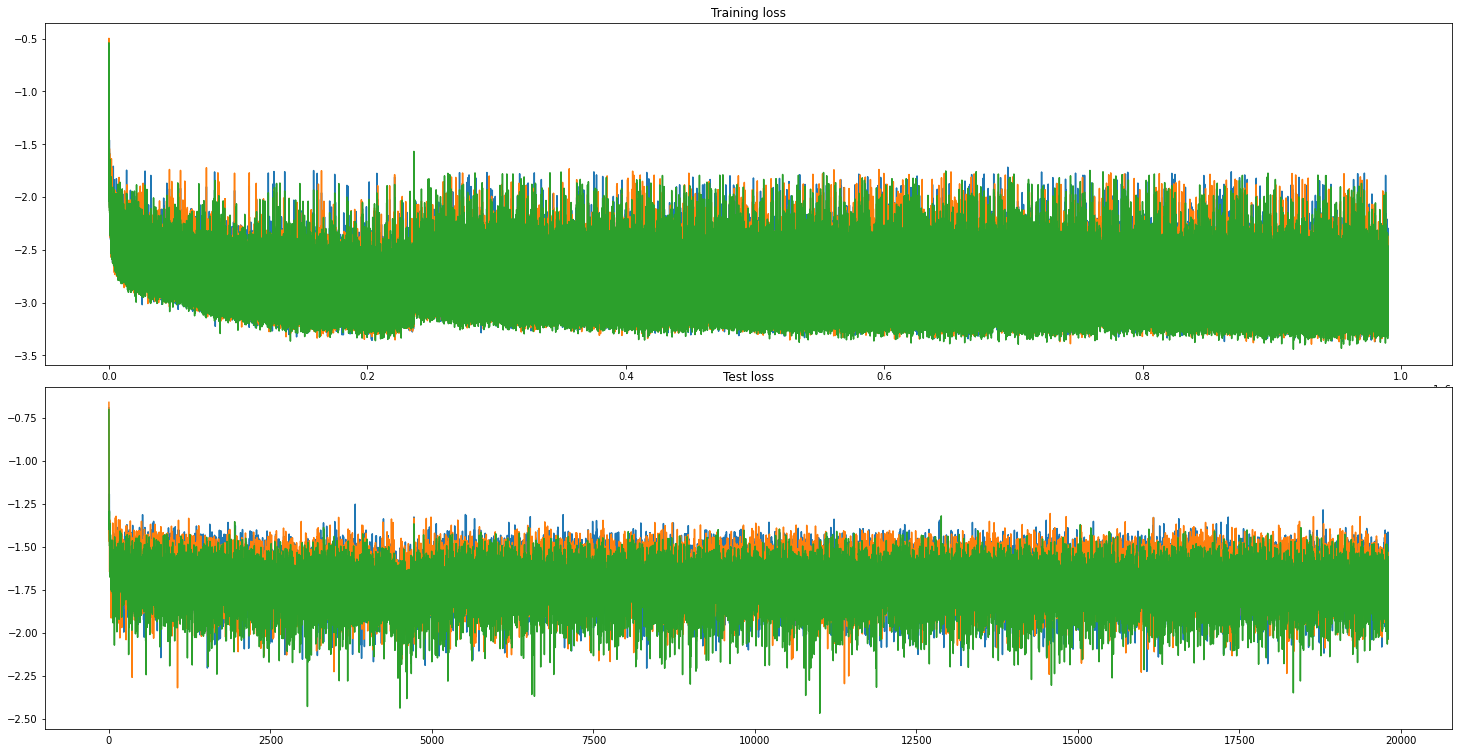

In [6]:
%matplotlib inline  

fig = plt.figure()
fig.set_size_inches(20, 20) 
ax = fig.add_subplot(411)
ax1 = fig.add_subplot(412)
plt.ion()

fig.canvas.draw()
fig.show()

 #loss graphs
fig.tight_layout(pad = 0.1)
ax.clear()
ax.title.set_text("Training loss")
ax.plot(losses)

ax1.clear()
ax1.title.set_text("Test loss")
ax1.plot(test_losses) 
        
# #compare network out put and data
# ax2.clear()
# ax2.title.set_text("Network output comparison")
# c = given_data[0][0].cpu()
# a = torch.arange(-params['past_seq_len'], 0).unsqueeze(-1).unsqueeze(-1).float()
# c = torch.cat((a,c), dim = 1)
# candlestick_ohlc(ax2, c.squeeze(), colorup = "green", colordown = "red")

# ax2.plot(net_out[:,0], color = "red")
# ax2.plot(net_out[:,1], color = "blue")
# ax2.plot(net_out[:,2], color = "red")
# ax2.plot(given_data[3].cpu().detach().numpy()[0], label = "target", color = "orange")

# #visualise variable selection weights
# vs_weights = torch.mean(torch.mean(vs_weights, dim = 0), dim = 0).squeeze()
# vs_weights = vs_weights.cpu().detach().numpy()
# ax3.clear()
# ax3.title.set_text("Variable Selection Weights")
# plt.xticks(rotation=-30)
# x = params['continuous_columns'] + params['discrete_columns']
# ax3.bar(x = x, height = vs_weights)
# fig.canvas.draw()

In [ ]:
%matplotlib inline  
from IPython.core.debugger import set_trace


fig = plt.figure()
ax = fig.add_subplot(411)
ax1 = fig.add_subplot(412)
ax2 = fig.add_subplot(413)
ax3 = fig.add_subplot(414)
plt.ion()

fig.canvas.draw()
fig.show()

steps = 1500000
for e in range(steps):
    #run model against test set every 50 batches
    if(len(losses) % 50 == 0 and len(losses) != 0 ):
        t.eval()
        m_test_losses = []
        for i in range(params['n_tests']):
            test_loss,_ , _, _ = forward_pass(t, test_data_gens, params['test_batch_size'], quantiles, test_indexer)
            m_test_losses.append(test_loss.cpu().detach().numpy())
            del test_loss
            del _
        
        test_losses.append(np.log10(np.array(m_test_losses).mean(axis = 0)))
        t.train()
        
    #save model every 400 batches
    if(len(losses) % 10000 == 0 and len(losses) != 0):
        torch.save({'model_state' : t,
                    'optimizer_state': optimizer,
                   'losses' : losses, 'test_losses' : test_losses} , dir + "model_{}.pt".format(len(losses)))
    #forward pass
    optimizer.zero_grad()
    loss, net_out, vs_weights, given_data = forward_pass(t,  train_data_gens , params['batch_size'], quantiles, indexer)
    
    net_out = net_out.cpu().detach()[0]#[0]
    #backwards pass
    losses.append(np.log10(loss.cpu().detach().numpy()))
    torch.mean(loss).backward()
    optimizer.step()
     
    if(e % 50 == 0):
        #loss graphs
        fig.tight_layout(pad = 0.1)
        ax.clear()
        ax.title.set_text("Training loss")
        ax.plot(losses)

        ax1.clear()
        ax1.title.set_text("Test loss")
        ax1.plot(test_losses) 
        
        #compare network out put and data
        ax2.clear()
        ax2.title.set_text("Network output comparison")
        c = given_data[0][0].cpu()
        a = torch.arange(-params['past_seq_len'], 0).unsqueeze(-1).unsqueeze(-1).float()
        c = torch.cat((a,c), dim = 1)
        candlestick_ohlc(ax2, c.squeeze(), colorup = "green", colordown = "red")

        ax2.plot(net_out[:,0], color = "red")
        ax2.plot(net_out[:,1], color = "blue")
        ax2.plot(net_out[:,2], color = "red")
        ax2.plot(given_data[3].cpu().detach().numpy()[0], label = "target", color = "orange")

        #visualise variable selection weights
        vs_weights = torch.mean(torch.mean(vs_weights, dim = 0), dim = 0).squeeze()
        vs_weights = vs_weights.cpu().detach().numpy()
        ax3.clear()
        ax3.title.set_text("Variable Selection Weights")
        plt.xticks(rotation=-30)
        x = params['continuous_columns'] + params['discrete_columns']
        ax3.bar(x = x, height = vs_weights)
        fig.canvas.draw()
    
    del loss
    del net_out
    del vs_weights
    del given_data


In [128]:
loss, net_out, vs_weights, given_data = forward_pass(t, test_data_gens, params['test_batch_size'], quantiles)

# print(given_data)

# net_out = net_out.cpu().detach()
# t.eval()
 
del loss
del net_out
del vs_weights
del given_data

In [ ]:
%matplotlib inline  

#Draw test cases
 

axes = []
batch_size_ = 2

fig, ax =plt.subplots(batch_size_,1)
fig.set_size_inches(20, 30) 

# for i in range(batch_size_):
#     axes.append(plt.subplot(gs[0]))
#     axes.append(plt.subplot(gs[1], sharex=axes[0]))
#     axes[0].get_xaxis().set_visible(False)
#     #axes.append(fig.add_subplot(911 + i)) 

fig.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

loss, net_out, vs_weights, given_data = forward_pass(t, test_data_gens, params['test_batch_size'], quantiles)
# loss, net_out, vs_weights, given_data = forward_pass(t, test_data_gens, 20, quantiles)

c = given_data[0][idx].cpu()
    
past_seq_len = params['past_seq_len']
b = torch.arange(-params['past_seq_len'], 0).unsqueeze(-1).unsqueeze(-1).float()
c = torch.cat((b,c), dim = 1)#[250:]
    
import pdb
pdb.set_trace()

net_out = net_out.cpu().detach()
for idx, a in enumerate(ax):
    a.clear()
    a.title.set_text("Network output comparison " + str(idx))
    c = given_data[0][idx].cpu()
    
    past_seq_len = params['past_seq_len']
    b = torch.arange(-params['past_seq_len'], 0).unsqueeze(-1).unsqueeze(-1).float()
    c = torch.cat((b,c), dim = 1)#[250:]
    #print(c.shape)
    candlestick_ohlc(a, c.squeeze(), colorup = "red", colordown = "blue")
    
    a.plot(net_out[idx][:,0], color = "red")
    a.plot(net_out[idx][:,1], color = "green")
    a.plot(net_out[idx][:,2], color = "blue")
    a.plot(given_data[3].cpu().detach().numpy()[idx], label = "target", color = "black")
    #a.bar(-past_seq_len, c[:][4], color='k', width=0.6, align='center')
    a.legend()

# t.train()    
plt.legend()
fig.show()
fig.canvas.draw()

del loss
del net_out
del vs_weights
del given_data

In [ ]:
np.array(losses ).argmin() #* 50

In [94]:
np.array(test_losses)[:,0].min() #* 50#.shape

-2.025053

In [1]:
!nvidia-smi

Fri Aug  6 03:29:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:82:00.0 Off |                    0 |
| N/A   19C    P8     9W / 250W |      0MiB / 22919MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()